# Civility in Communication

The focus of this assignment will be on a) training a classifier to perform hate speech detection; b) use LIME to explain the classifier's behaviour; c) establish whether the classifier might be biased wrt. different demographic dialects.

This assignment is divided into three parts:
1. **Before the laboratory** (individually): read [LIME's paper](https://arxiv.org/abs/1602.04938) and understand how its Python implementation works: https://github.com/marcotcr/lime (docs: https://lime-ml.readthedocs.io/en/latest/index.html). Check these tutorials in particular: [1](https://marcotcr.github.io/lime/tutorials/Lime%20-%20basic%20usage%2C%20two%20class%20case.html) and [2](https://marcotcr.github.io/lime/tutorials/Lime%20-%20multiclass.html). Furthermore, download the dataset, read its description below and make sure you understand it. Finally, implement a classifier to detect offensive language (use the "label" column in the train and dev datasets). You could for example use a TF-IDF model with any classifier you like from sklearn. Your focus, before the laboratory, is to clearly understand LIME and the proposed dataset, as well as to bring your own classifier to the laboratory.
2. **During the laboratory** (in groups): compare your classifiers and chose one or two to work with (e.g., select the best-performing ones, or those using different methods). Split into two sub-groups: one will use LIME to come-up with explanations for classifications. In particular, they will focus on missclassifications and try to explain those. Another group will select a definition of bias (from literature - can be from week 2 or any other literature you find) and verify whether your classifier(s) are biased wrt. different demgraphic dialects. For this task, use your classifier(s) on the “mini_demographic_dev.tsv” dataset, and assess bias by demographic group (see below for details). At the end of the laboratory, try to combine your work by using LIME to explain biased classifications.
3. **After the laboratory** (in groups): wrap-up your work and write up your results and thoughts into a brief project report. Make sure to discuss the question of whether you think LIME is effective at explaining your classifier(s), whether you found bias in the classifier, and whether LIME explains biased classifications well (or not).

## Dataset

*This dataset and text is taken with permission from the [Computational Ethics for NLP course, HW2](http://demo.clab.cs.cmu.edu/ethical_nlp2020/homeworks/hw2/hw2.html).*

The primary data for this assignment is available in the dataset folder. **Please note that the data contains offensive or sensitive content, including profanity and racial slurs.**

We provide data drawn from two sources. The first (files "train.tsv" and "dev.tsv") consists of tweets annotated for offensiveness taken from the [2019 SemEval task](https://competitions.codalab.org/competitions/20011) on offensive language detection. In the files "train.tsv" and "dev.tsv", the first column (text) contains the text of a tweet, the second column (label) contains an offensiveness label:

* (NOT) Not Offensive - This post does not contain offense or profanity.
* (OFF) Offensive - This post contains offensive language or a targeted (veiled or direct) offense

The file “offenseval-annotation.txt” provides additional details on the annotation scheme.

We additionally provide a data set of tweets proxy-labelled for race in the file titled “mini_demographic_dev.tsv”. This data is taken from the [TwitterAAE](http://slanglab.cs.umass.edu/TwitterAAE/) data set and uses posterior proportions of demographic topics as a proxy for racial dialect ([details](https://www.aclweb.org/anthology/D16-1120.pdf)). The first column (“text”) contains the text of the tweet, and the second column (“demographic”) contains a label: “AA” (for “African American”), “White”, “Hispanic”, or “Other”. For this assignment, we assume that no tweet in the TwitterAAE data set contains toxic language. Thus, any tweet in this file that is classified as toxic is a false positive.

Finally, both development sets (“dev.tsv” and “mini_demographic_dev.tsv”) contain a column “perspective_score”, which contains a toxicity score. These scores were obtain using the [PerspectiveAPI tool](https://www.perspectiveapi.com/) released by Alphabet. This tool is intended to help “developers and publishers…give realtime feedback to commenters or help moderators do their job”

In all data sets, user mentions have been replaced with the token @USER.

In [23]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import nltk, sklearn

import random
from lime.lime_text import LimeTextExplainer



### Load and inspect the dataset

In [24]:
df_train = pd.read_csv("dataset/civility_data/train.tsv", sep="\t")
df_dev = pd.read_csv("dataset/civility_data/dev.tsv", sep="\t")
df_test = pd.read_csv("dataset/civility_data/test.tsv", sep="\t")
df_demo = pd.read_csv("dataset/civility_data/mini_demographic_dev.tsv", sep="\t")

In [25]:
print(df_train.shape)

(10592, 3)


In [26]:
df_train.head()

,text,label,category
0,@USER @USER You are an embarrassing citizen!!,OFF,TIN
1,@USER Seems hard to believe that you stood nex...,OFF,TIN
2,@USER @USER @USER Wow !!! no wonder the Libera...,OFF,TIN
3,@USER @USER And not all idiots grandstands lik...,OFF,TIN
4,@USER Bring on the hypocrite gungrabber. MAGA,OFF,TIN


In [27]:
df_demo.head()

,text,demographic,perspective_score
0,People make mistakes. It takes a good person t...,White,0.041031
1,"Only one on our road with power, but no cable ...",White,0.061435
2,I love when baby's yawn I think it's so cute.,White,0.056817
3,theres so many hoes now that i actually think ...,White,0.503459
4,Today is the day Adalynn Alexis will be here! ...,White,0.092183


## Train a classifier

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train = df_train['text']
y_train = df_train['label']

X_dev = df_dev['text']
y_dev = df_dev['label']

vectorizer = TfidfVectorizer(
    analyzer='char_wb',
    ngram_range=(4,6),
    min_df=5,
    max_features=300000
)

X_train_t = vectorizer.fit_transform(X_train)
X_dev_t = vectorizer.transform(X_dev)

model = RandomForestClassifier(n_estimators=200, random_state=1)
model.fit(X_train_t, y_train)
y_pred = model.predict(X_dev_t)

print(classification_report(y_dev, y_pred))

              precision    recall  f1-score   support

         NOT       0.77      0.93      0.84       884
         OFF       0.76      0.44      0.55       440

    accuracy                           0.77      1324
   macro avg       0.77      0.68      0.70      1324
weighted avg       0.77      0.77      0.75      1324



## Explain with LIME

In [57]:
def predict_proba_lime(texts):
    X = vectorizer.transform(texts)
    return model.predict_proba(X)

class_names = model.classes_
explainer = LimeTextExplainer(class_names=class_names)

random_index = random.choice(np.where(y_dev != y_pred)[0])

text_instance = X_dev.iloc[random_index]
print('Text to explain:\n', text_instance)

true_label = y_dev.iloc[random_index]
pred_label = y_pred[random_index]

print('\nRandom index: ', random_index)
print('True label:', true_label)
print('Predicted label:', pred_label)

exp = explainer.explain_instance(
    text_instance,
    predict_proba_lime,
    num_features=10
)

print('\nLIME explanation:')
for feature, weight in exp.as_list():
    print(f"{feature}: {weight:.3f}")

Text to explain:
 .@USER As my elected MP could you please explain why @USER is still promoting ideas that the EU have already rejected? We've 6 months to go and nothing appears to be moving onward. @USER are like the blind leading the blind #brexitshambles #BrexitMeansBrexit URL

Random index:  408
True label: OFF
Predicted label: NOT

LIME explanation:
blind: 0.149
URL: -0.024
brexitshambles: 0.013
could: 0.012
that: -0.011
BrexitMeansBrexit: -0.009
the: -0.009
promoting: 0.008
nothing: 0.008
USER: 0.006


Best word: blind
Removed feature: "blind"
Removed feature: " blind"
Removed feature: "blind "

Original prediction:
  class = NOT, probability = 0.3250

Prediction removing best word:
  class = NOT, probability = 0.2850

Difference in probability: -0.040000000000000036


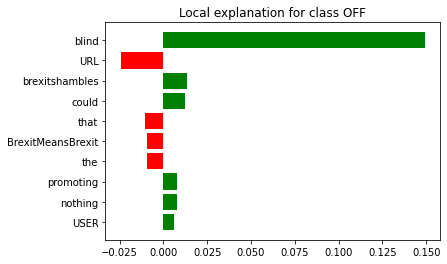

In [ ]:
feature_weights = exp.as_list()
feature_weights = sorted(feature_weights, key=lambda x: abs(x[1]), reverse=True)

best_word = feature_weights[0][0].lower()
print(f"Best word: {best_word}")

tmp = vectorizer.transform([text_instance]).copy()

variants = [
    best_word,
    f" {best_word}",
    f"{best_word} "
]

for v in variants:
    if v in vectorizer.vocabulary_:
        print(f'Removed feature: "{v}"')
        tmp[0, vectorizer.vocabulary_[v]] = 0

# ---- Predictions ----
orig_vec = vectorizer.transform([text_instance])

orig_proba = model.predict_proba(orig_vec)[0, 1]
new_proba = model.predict_proba(tmp)[0, 1]

orig_pred = model.predict(orig_vec)[0]
new_pred = model.predict(tmp)[0]

print('\nOriginal prediction:')
print(f'  class = {orig_pred}, probability = {orig_proba:.4f}\n')
print('Prediction removing best word:')
print(f'  class = {new_pred}, probability = {new_proba:.4f}\n')
print('Difference in probability:', new_proba - orig_proba)

fig = exp.as_pyplot_figure()
plt.show()

## A biased classifier?

In [30]:
# Your code here